In [ ]:
!git add source_MLM.ipynb
!git commit

# Mainly for the bias classifer
## Includes a mixture of components not in order
## Logistic Regression is at the bottom

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import BertTokenizer, BertModel
import pickle
import tensorflow_hub as hub
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import pandas as pd
import numpy as np
import seaborn as sns
import nltk
from nltk.tokenize import sent_tokenize
#nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
#nltk.download('punkt')
#nltk.download('punkt_tab')
from nltk.tokenize import word_tokenize
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
import pickle
import torch
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import RandomizedSearchCV
from tensorflow.keras.optimizers import Adam
from scipy.stats import uniform, randint
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

In [2]:
# Load ELMo headline embeddings
with open("headline_embeddings.pkl", "rb") as f:
    elmo_headline_embeddings = pickle.load(f)

In [3]:
corpus = pd.read_csv('corpus.csv')
corpus_df = corpus.copy()

In [4]:
elmo_headline_embeddings.shape
#bert_headline_embeddings.shape

(502, 29, 1024)

In [5]:
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = BertModel.from_pretrained('bert-base-uncased')
headlines = corpus_df['headline'].tolist()

max_len = max(len(bert_tokenizer.tokenize(h)) for h in headlines)


def get_bert_embeddings(text_list, max_len=max_len):
    """
    Tokenizes and returns BERT embeddings for a list of texts with optional max_len.
    """

    # Tokenize with dynamic max length padding
    inputs = bert_tokenizer(
        text_list,
        padding='max_length',
        truncation=True,
        max_length=max_len,
        return_tensors='pt' # pytorch tensors
    )

    with torch.no_grad(): # does not compute gradients
        outputs = bert_model(**inputs)
    
    # Shape: (batch_size, max_len, 768)
    return outputs.last_hidden_state

def get_bert_embeddings_numpy(text_list, max_len=None):
    """
    Same as get_bert_embeddings but returns NumPy array.
    """
    embeddings = get_bert_embeddings(text_list, max_len)
    return embeddings.detach().cpu().numpy()

bert_headline_embeddings = get_bert_embeddings(headlines)
bert_headline_embeddings.shape

torch.Size([502, 32, 768])

## Supervised Model BERT

In [91]:
np.sum(y_source, axis=0) # balanced

array([160, 169, 173])

In [102]:
y_source = pd.get_dummies(corpus_df['source']).to_numpy()
def train_lstm_classifier(X, y, max_length, embedding_dim, num_classes=3, 
                          lstm_units=64, dropout_rate=0.3, dense_units=32,
                          batch_size=16, epochs=6, validation_split=0.2):
    """
    Train an LSTM model on the given data.
    
    Parameters:
        X (ndarray): Input embeddings of shape (samples, max_length, embedding_dim)
        y (ndarray): One-hot encoded labels
        max_length (int): Max sequence length
        embedding_dim (int): Embedding dimensionality (e.g. 1024 for ELMo, 768 for BERT)
        num_classes (int): Number of output classes
        lstm_units (int): Number of LSTM units
        dropout_rate (float): Dropout rate
        dense_units (int): Units in dense layer
        batch_size (int): Batch size
        epochs (int): Number of training epochs
        validation_split (float): Fraction of data used for validation
    
    Returns:
        model (tf.keras.Model): Trained model
        history: Training history
        evaluation: (loss, accuracy) on test set
    """
    indices = np.arange(len(X))
    X_train, X_test, y_train, y_test, idx_train, idx_test = train_test_split(
        X, y, indices, test_size=validation_split, random_state=42
    )

    model = tf.keras.Sequential([
        tf.keras.layers.InputLayer(input_shape=(max_length, embedding_dim)),
        tf.keras.layers.LSTM(lstm_units, return_sequences=False),
        tf.keras.layers.Dropout(dropout_rate),
        tf.keras.layers.Dense(dense_units, activation='relu'),
        tf.keras.layers.Dense(num_classes, activation='softmax')
    ])

    model.compile(loss='categorical_crossentropy',
                  optimizer=Adam(learning_rate=0.001),
                  metrics=['accuracy'])

    history = model.fit(X_train, y_train,
                        epochs=epochs,
                        batch_size=batch_size,
                        validation_data=(X_test, y_test))
    
    y_pred_probs = model.predict(X_test)
    y_pred = np.argmax(y_pred_probs, axis=1)
    y_true = np.argmax(y_test, axis=1)

    evaluation = model.evaluate(X_test, y_test)
    print(f"Test Loss: {evaluation[0]}, Test Accuracy: {evaluation[1]}")

    return model, history, evaluation, y_pred, y_true


In [103]:
#Best: 0.713205 using {'model__dense_units': 32, 'model__drop_rate': 0.3, 'model__units': 64, 'optimizer__learning_rate': 0.001
model_bert, history_bert, eval_bert, y_pred_bert, y_true_bert = train_lstm_classifier(
    X=bert_headline_embeddings,
    y=y_source,
    max_length=max_len,  # dynamically determined
    embedding_dim=768
)

Epoch 1/6


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.4193 - loss: 1.0781 - val_accuracy: 0.5248 - val_loss: 0.9701
Epoch 2/6
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.6084 - loss: 0.8397 - val_accuracy: 0.5743 - val_loss: 0.9236
Epoch 3/6
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.6936 - loss: 0.7138 - val_accuracy: 0.6832 - val_loss: 0.8088
Epoch 4/6
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7735 - loss: 0.5696 - val_accuracy: 0.7129 - val_loss: 0.7496
Epoch 5/6
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.8325 - loss: 0.4265 - val_accuracy: 0.7228 - val_loss: 0.7484
Epoch 6/6
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.8700 - loss: 0.2917 - val_accuracy: 0.7624 - val_loss: 0.7062
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7758 - loss: 0.6651
Test Loss: 0.7062248587608337, Test Accuracy: 0.7623762488365173


In [81]:
from sklearn.metrics import classification_report
print("BERT Report")
print(classification_report(y_true_bert, y_pred_bert))

BERT Report
              precision    recall  f1-score   support

           0       0.74      0.65      0.69        31
           1       0.81      0.76      0.79        34
           2       0.74      0.86      0.79        36

    accuracy                           0.76       101
   macro avg       0.76      0.76      0.76       101
weighted avg       0.76      0.76      0.76       101



In [117]:
print(np.mean(y_pred_bert==y_true_bert))

0.7623762376237624


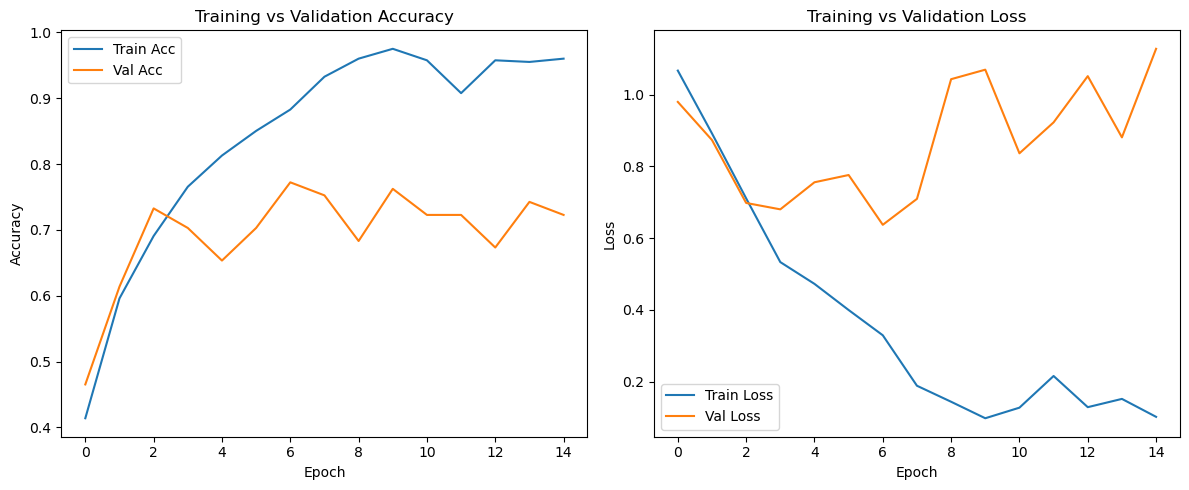

In [68]:
def plot_training_history(history):
    plt.figure(figsize=(12, 5))

    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Acc')
    plt.plot(history.history['val_accuracy'], label='Val Acc')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training vs Validation Accuracy')
    plt.legend()

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training vs Validation Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_training_history(history_bert)

## ELMo

In [75]:
# Best: 0.711185 using {'model__dense_units': 32, 'model__drop_rate': 0.2, 'model__units': 64, 'optimizer__learning_rate': 0.01}
model_elmo, history_elmo, eval_elmo, y_pred_elmo, y_true_elmo = train_lstm_classifier(
    X=elmo_headline_embeddings,
    y=y_source,
    max_length=29,
    embedding_dim=1024
)

Epoch 1/6


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy: 0.4891 - loss: 1.0329 - val_accuracy: 0.6733 - val_loss: 0.7626
Epoch 2/6
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.6748 - loss: 0.8097 - val_accuracy: 0.6634 - val_loss: 0.7192
Epoch 3/6
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7216 - loss: 0.6313 - val_accuracy: 0.7129 - val_loss: 0.7031
Epoch 4/6
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.8147 - loss: 0.4215 - val_accuracy: 0.7228 - val_loss: 0.6990
Epoch 5/6
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.8971 - loss: 0.3206 - val_accuracy: 0.6634 - val_loss: 0.9000
Epoch 6/6
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.8799 - loss: 0.3436 - val_accuracy: 0.6832 - val_loss: 0.9074
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.6785 - loss: 0.9459
Test Loss: 0.9074053764343262, Test Accuracy: 0.6831682920455933


In [126]:
print("ELMo Report")
print(classification_report(y_true_elmo, y_pred_elmo))

ELMo Report
              precision    recall  f1-score   support

           0       0.61      0.74      0.67        31
           1       0.90      0.53      0.67        34
           2       0.65      0.78      0.71        36

    accuracy                           0.68       101
   macro avg       0.72      0.68      0.68       101
weighted avg       0.72      0.68      0.68       101



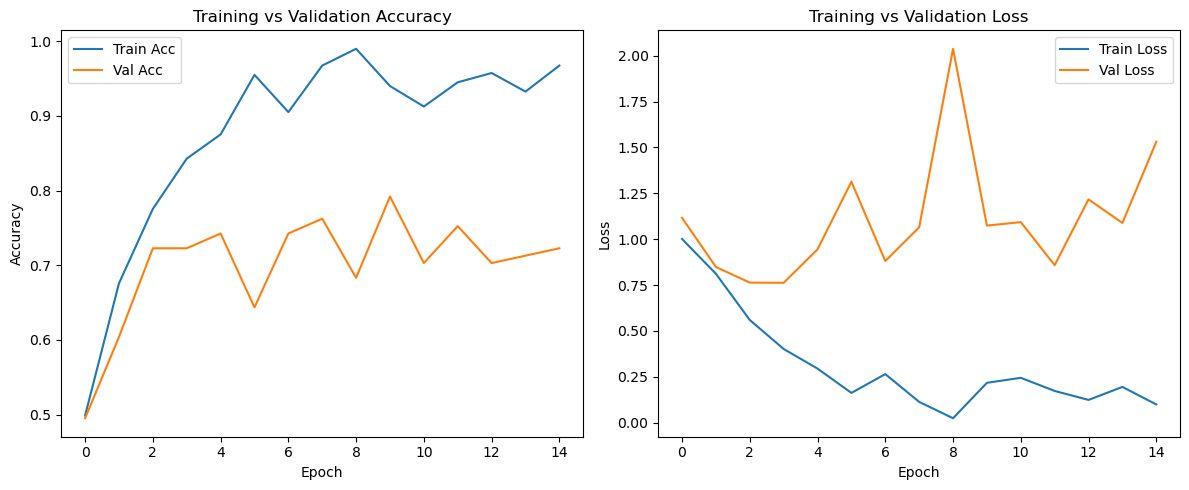

In [73]:
plot_training_history(history_elmo)

In [25]:
categories = pd.get_dummies(corpus_df['source']).columns
categories

Index(['abc', 'skynews', 'theguardian'], dtype='object')

# Hyperparameter Tuning
## BERT

In [57]:
from tensorflow.keras.callbacks import EarlyStopping

def create_model(units=128, learning_rate=0.001, drop_rate=0.2, dense_units=64):
    """LSTM model for tuning"""
    model = Sequential()
    model.add(LSTM(units=units, input_shape=(32, 768)))  # change for BERT or ELMo input
    model.add(Dropout(rate=drop_rate))
    model.add(Dense(dense_units, activation='relu'))
    model.add(Dense(3, activation='softmax'))  # 3 classes in output layer
    model.compile(optimizer=Adam(learning_rate=learning_rate), 
                  loss='categorical_crossentropy', 
                  metrics=['accuracy'])
    return model

def grid_search_model(X, y, param_grid, verbose=0):
    """Function for hyperparameter tuning"""
    # Fix random seed for reproducibility
    seed = 7
    tf.random.set_seed(seed)

    # Create the KerasClassifier
    model = KerasClassifier(model=create_model, epochs=10, batch_size=16, verbose=0)

    # Create GridSearchCV object
    grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)

    # Fit the grid search with early stop depending on loss
    early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
    grid_result = grid.fit(X, y, callbacks=[early_stop], validation_split=0.2)

    print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

    # Show the mean and standard deviation of each parameter setting
    means = grid_result.cv_results_['mean_test_score']
    stds = grid_result.cv_results_['std_test_score']
    params = grid_result.cv_results_['params']

    for mean, stdev, param in zip(means, stds, params):
        print("%f (%f) with: %r" % (mean, stdev, param))

    return grid_result.best_params_, grid_result.best_score_

# Define the grid search parameters
learn_rate = [0.001, 0.01, 0.1]
unit_size = [64, 128]  # Different sizes for LSTM units
drop_rate = [0.2, 0.3, 0.5]
dense_units = [16, 32, 64]

# Param grid for grid search
param_grid = dict(optimizer__learning_rate=learn_rate, 
                  model__units=unit_size,
                  model__drop_rate=drop_rate, 
                  model__dense_units=dense_units)

In [58]:
best_params_bert, best_score_bert = grid_search_model(bert_headline_embeddings, y_source, param_grid)

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim`

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim`

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim`

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim`

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim`

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim`

Best: 0.713205 using {'model__dense_units': 32, 'model__drop_rate': 0.3, 'model__units': 64, 'optimizer__learning_rate': 0.001}
0.635693 (0.088336) with: {'model__dense_units': 16, 'model__drop_rate': 0.2, 'model__units': 64, 'optimizer__learning_rate': 0.001}
0.651554 (0.056710) with: {'model__dense_units': 16, 'model__drop_rate': 0.2, 'model__units': 64, 'optimizer__learning_rate': 0.01}
0.663494 (0.052701) with: {'model__dense_units': 16, 'model__drop_rate': 0.2, 'model__units': 64, 'optimizer__learning_rate': 0.1}
0.703272 (0.030487) with: {'model__dense_units': 16, 'model__drop_rate': 0.2, 'model__units': 128, 'optimizer__learning_rate': 0.001}
0.705221 (0.067607) with: {'model__dense_units': 16, 'model__drop_rate': 0.2, 'model__units': 128, 'optimizer__learning_rate': 0.01}
0.675435 (0.057809) with: {'model__dense_units': 16, 'model__drop_rate': 0.2, 'model__units': 128, 'optimizer__learning_rate': 0.1}
0.699292 (0.032330) with: {'model__dense_units': 16, 'model__drop_rate': 0.3,

In [109]:
best_params_bert

{'model__dense_units': 32,
 'model__drop_rate': 0.3,
 'model__units': 64,
 'optimizer__learning_rate': 0.001}

## ELMo

In [59]:
best_params_elmo, best_score_elmo = grid_search_model(bert_headline_embeddings, y_source, param_grid)

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim`

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim`

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim`

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim`

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim`

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim`

Best: 0.711185 using {'model__dense_units': 32, 'model__drop_rate': 0.2, 'model__units': 64, 'optimizer__learning_rate': 0.01}
0.679344 (0.029131) with: {'model__dense_units': 16, 'model__drop_rate': 0.2, 'model__units': 64, 'optimizer__learning_rate': 0.001}
0.681411 (0.049829) with: {'model__dense_units': 16, 'model__drop_rate': 0.2, 'model__units': 64, 'optimizer__learning_rate': 0.01}
0.643594 (0.060690) with: {'model__dense_units': 16, 'model__drop_rate': 0.2, 'model__units': 64, 'optimizer__learning_rate': 0.1}
0.667463 (0.047871) with: {'model__dense_units': 16, 'model__drop_rate': 0.2, 'model__units': 128, 'optimizer__learning_rate': 0.001}
0.677324 (0.020755) with: {'model__dense_units': 16, 'model__drop_rate': 0.2, 'model__units': 128, 'optimizer__learning_rate': 0.01}
0.651447 (0.030779) with: {'model__dense_units': 16, 'model__drop_rate': 0.2, 'model__units': 128, 'optimizer__learning_rate': 0.1}
0.657530 (0.057977) with: {'model__dense_units': 16, 'model__drop_rate': 0.3, 

In [127]:
best_params_elmo

{'model__dense_units': 32,
 'model__drop_rate': 0.2,
 'model__units': 64,
 'optimizer__learning_rate': 0.01}

## BERT Embeddings are the final choice

In [82]:
# saving BERT embeddings

# Save embeddings to a file using pickle
with open('bert_headline_embeddings.pkl', 'wb') as f:
    pickle.dump(bert_headline_embeddings, f)

In [112]:
X_cls = bert_headline_embeddings[:, 0, :]  # Select the first token (CLS) for each sequence
X_cls.shape

torch.Size([502, 768])

## Extra Optional XGBoost Model (ran out of words to include this)

In [114]:
#!pip install xgboost
import xgboost as xgb

X_train_xgb, X_test_xgb, y_train_xgb, y_test_xgb = train_test_split(X_cls, y_source, test_size=0.2, random_state=42)

# Step 4: Train an XGBoost model on the embeddings
xgb_model = xgb.XGBClassifier()
xgb_model.fit(X_train_xgb, y_train_xgb)

# Step 5: Evaluate the model
y_pred_xgb = xgb_model.predict(X_test_xgb)
print(classification_report(y_test_xgb, y_pred_xgb))

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 12.8 MB/s eta 0:00:00a 0:00:01
              precision    recall  f1-score   support

           0       0.70      0.61      0.66        31
           1       0.69      0.71      0.70        34
           2       0.76      0.44      0.56        36

   micro avg       0.71      0.58      0.64       101
   macro avg       0.72      0.59      0.64       101
weighted avg       0.72      0.58      0.64       101
 samples avg       0.57      0.58      0.58       101



/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [116]:
print(np.mean(y_pred_xgb==y_test_xgb))

0.7821782178217822


## Logistic Regression

In [123]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder

# Download NLTK resources
#nltk.download('punkt')
#nltk.download('stopwords')
#nltk.download('wordnet')

# Initialize lemmatizer and stopwords
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def nltk_tokenizer(text):
    """tokenizer and preprocessing using NLTK"""
    # Tokenize the text
    tokens = nltk.word_tokenize(text)
    
    # Remove stopwords and non-alphabetic words, then lemmatize
    cleaned_tokens = [
        lemmatizer.lemmatize(token.lower()) 
        for token in tokens 
        if token.isalpha() and token.lower() not in stop_words
    ]
    
    return cleaned_tokens

# Vectorize the headlines using TF-IDF
vectorizer = TfidfVectorizer(tokenizer=nltk_tokenizer, lowercase=False)
X_tfidf = vectorizer.fit_transform(corpus_df['headline'])

# Encode the target labels using onehot encoding
y_encoded = pd.get_dummies(corpus_df['source']).to_numpy()  # Encode the categorical labels
y_encoded_flat = np.argmax(y_encoded, axis=1)
# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y_encoded_flat, test_size=0.2, random_state=42)

# Train a Logistic Regression model
model_lr = LogisticRegression(max_iter=1000, multi_class='ovr')  # 'ovr' for multi-class
model_lr.fit(X_train, y_train)

# Make predictions
y_pred = model_lr.predict(X_test)

# Evaluate the model using classification metrics
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.36      0.26      0.30        31
           1       0.63      0.71      0.67        34
           2       0.56      0.64      0.60        36

    accuracy                           0.54       101
   macro avg       0.52      0.53      0.52       101
weighted avg       0.52      0.54      0.53       101

0.5445544554455446


/opt/anaconda3/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
